In diesem Notebook implementieren wir zwei Versionen für die Mengenbasierte Mehrzieloptimierung. Die Idee und mathematischem Grudlagen stammen aus den folgenden Arbeiten:

[Dissertation Sebastian Peitz](https://digital.ub.uni-paderborn.de/ubpb/urn/urn:nbn:de:hbz:466:2-29240)

[Dissertation Oliver Schütze](https://digital.ub.uni-paderborn.de/ubpb/urn/urn:nbn:de:hbz:466-20040101418)

In [1]:
%matplotlib notebook

In [2]:
# imports
from anytree import AnyNode, RenderTree, LevelOrderGroupIter
from anytree.cachedsearch import findall
from numpy import array, stack, copy, absolute
from numpy import sum as npsum
from numpy import all as npall
from itertools import product

In [3]:
# imports for plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Einfacher Subdivision Algorithmus mit pareto-Filter

Subdivision: Wir teilen den Wertebereich in viele Hyperwürfel

Evaluation: Wir werten die zu minimierenden Funktionen im Zentrum jedes Hyperwürfels aus

Pareto-Filter: Wir prüfen, ob die Werte(-paare) pareto optimal sind und streichen alle Hyperwürfel mit nicht pareto-optimalem Zentrum

In [4]:
# classes
class Hypercube():
    """Class for n-dimensional cube"""

    def __init__(self, center, radius, dimension):
        self.center = center
        self.radius = radius
        self.dimension = dimension
        return
    
    def is_in(self, point):
        # point can be in two boxes with this definition
        # but only if point exactly hits box edge
        diff = absolute(self.center - point)
        return npall(diff < self.radius)


class MyNode(AnyNode):
    def __init__(self, center, radius, dimension, evaluation=None, is_dominated=False, is_outer=False):
        super(MyNode, self).__init__()
        self.box = Hypercube(center, radius, dimension)
        self.evaluation = evaluation
        self.is_dominated = is_dominated
        self.is_outer = is_outer
        return

    def set_evaluation(self, evaluation):
        self.evaluation = evaluation
        return

In [5]:
# functions
def split_node(node: MyNode, offset=0, is_outer=False) -> None:
    new_radius = copy(node.box.radius)
    new_radius[offset] /= 2
    left_center = copy(node.box.center)
    right_center = copy(node.box.center)
    left_center[offset] -= new_radius[offset]
    right_center[offset] += new_radius[offset]
    node.children = [MyNode(left_center, new_radius, node.box.dimension, is_outer=is_outer), MyNode(
        right_center, new_radius, node.box.dimension, is_outer=is_outer)]
    return None


def full_split_leaves(node: MyNode) -> None:
    for dim in range(node.box.dimension):
        leaves = node.leaves
        for leaf in leaves:
            split_node(leaf, dim)
    return None


def test_dominance(node1, node2):
    x = node1.evaluation
    y = node2.evaluation
    is_better = False
    is_worse = False
    for i in range(len(x)):
        if x[i] < y[i]:
            is_better = True
        elif x[i] > y[i]:
            is_worse = True
    if is_better and not is_worse:
        # x dominates y
        return 1
    elif not is_better and is_worse:
        # y dominates x
        return -1
    else:
        # none is dominant
        return 0


def flag_dominated_leaves(node: MyNode) -> None:
    leaves = node.leaves
    num_leaves = len(leaves)
    for i in range(num_leaves):
        if not leaves[i].is_dominated:
            for j in range(i+1, num_leaves):
                flag = test_dominance(leaves[i], leaves[j])
                if flag == 1:
                    leaves[j].is_dominated = True
                if flag == -1:
                    leaves[i].is_dominated = True
                    break
    return None


def remove_dominated_leaves(node: MyNode) -> None:
    for node in list(findall(node, filter_=lambda node: node.is_dominated)):
        node.parent = None
    return None


def flag_dominated_parents(node: MyNode) -> None:
    depth = root.height
    while depth > 1:
        for parent in list(LevelOrderGroupIter(root, maxlevel=depth))[-1]:
            if npall([child.is_dominated for child in parent.children]):
                parent.is_dominated = True
        depth -= 1

### Beispiel 1:

\begin{equation}
    \begin{aligned}
        \min_x & 
            \begin{pmatrix}
                f_1(x) \\
                f_2(x)
            \end{pmatrix}:=
            \begin{pmatrix}
                x_1^2 + (x_2-1)^2 \\
                (x_1-1)^2 + x_2^2
            \end{pmatrix} \\[2mm]
        s.t. & -2 \leq x_1 \leq 2 \\
        & -2 \leq x_2 \leq 2
    \end{aligned}
\end{equation}

In [6]:
#example two parabolas
initial_splits = 3
total_iterations = 8

# set decision boundaries
domain_dim = 2  # =bounds.shape[0]
b1 = array([-2, 2])
b2 = array([-2, 2])
bounds = [b1, b2]

# set objectives
objective_dim = 2
def f1(x): return x[0]**2 + (x[1]-1)**2
def f2(x): return (x[0]-1)**2 + x[1]**2
functions = [f1, f2]

current_iteration = 0

# create root box/node
initial_center = array([b[0]+b[1] for b in bounds]) / 2
initial_radius = array([b[1]-b[0] for b in bounds]) / 2
root = MyNode(initial_center, initial_radius, domain_dim)

# split some iterations before dominance test
for _ in range(initial_splits):
    current_iteration += 1
    full_split_leaves(root)
print("The populaion in iteration {} is {}.".format(
    current_iteration, len(root.leaves)))

while current_iteration < total_iterations:
    current_iteration += 1
    # split
    full_split_leaves(root)
    print("The populaion in iteration {} is {} after subsection.".format(
        current_iteration, len(root.leaves)))
    # evaluate
    for leaf in root.leaves:
        leaf.set_evaluation(array([f(leaf.box.center) for f in functions]))
        #print(leaf)
    # dominance test and removal
    # use a very simple (linear) dom test to begin with
    # i could use a seperate(?) domination tree later
    flag_dominated_leaves(root)
    flag_dominated_parents(root)
    remove_dominated_leaves(root)
    print("The populaion in iteration {} is {} after sampling is applied.".format(
        current_iteration, len(root.leaves))) 

The populaion in iteration 3 is 64.
The populaion in iteration 4 is 256 after subsection.
The populaion in iteration 4 is 10 after sampling is applied.
The populaion in iteration 5 is 40 after subsection.
The populaion in iteration 5 is 22 after sampling is applied.
The populaion in iteration 6 is 88 after subsection.
The populaion in iteration 6 is 46 after sampling is applied.
The populaion in iteration 7 is 184 after subsection.
The populaion in iteration 7 is 94 after sampling is applied.
The populaion in iteration 8 is 376 after subsection.
The populaion in iteration 8 is 190 after sampling is applied.


<IPython.core.display.Javascript object>


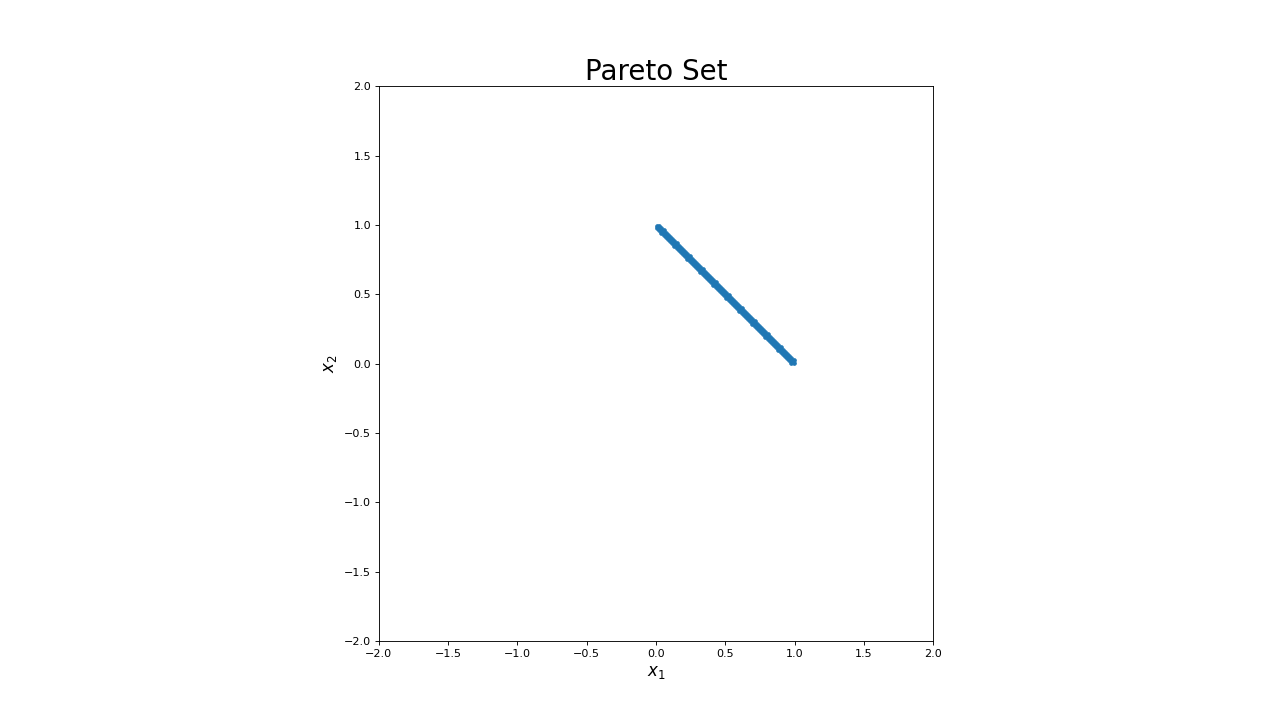

<IPython.core.display.Javascript object>


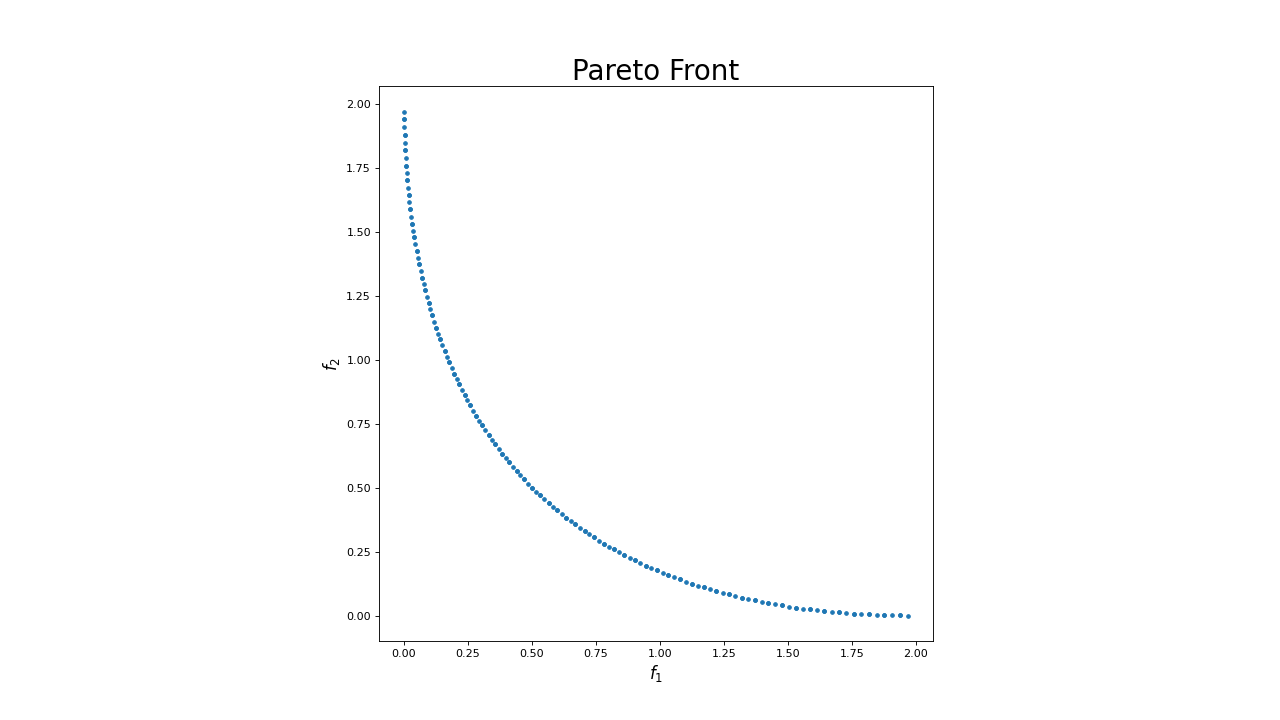

In [7]:
# plot
# plot 2d pareto set
x, y = array([leaf.box.center for leaf in root.leaves]).transpose()
fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot(xlim=bounds[0], ylim=bounds[1])
axes.set_box_aspect(1)
# axes.view_init(20, 160)
axes.set_title("Pareto Set", fontsize=25)
axes.set_xlabel("$x_1$", fontsize=15)
axes.set_ylabel("$x_2$", fontsize=15)
axes.scatter(x, y, s=10, marker='o')
plt.show()

# plot 2d pareto front
f, g = array([leaf.evaluation for leaf in root.leaves]).transpose()
fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot()
axes.set_box_aspect(1)
axes.set_title("Pareto Front", fontsize=25)
axes.set_xlabel("$f_1$", fontsize=15)
axes.set_ylabel("$f_2$", fontsize=15)
axes.scatter(f, g, s=10, marker='o')
plt.show()

---

Ein weietes Beispiel mit drei Variablen. Ich benutze das Beispiel 5.44 aus der [Dissertation von Sebastian Peitz](https://digital.ub.uni-paderborn.de/ubpb/urn/urn:nbn:de:hbz:466:2-29240).

\begin{equation}
    \begin{aligned}
        \min_{x\in \mathbb{R}^3}~ & 
            \begin{pmatrix}
                f_1(x) \\
                f_2(x) \\
                f_3(x)
            \end{pmatrix}:=
            \begin{pmatrix}
                (x_1-1)^4 + (x_2-1)^2 + (x_3-1)^2 \\
                (x_1+1)^2 + (x_2+1)^4 + (x_3+1)^2 \\
                (x_1-1)^2 + (x_2+1)^2 + (x_3-1)^4
            \end{pmatrix} \\[2mm]
        s.t. ~ & -2 \leq x_1 \leq 2 \\
        & -2 \leq x_2 \leq 2 \\
        & -2 \leq x_3 \leq 2
    \end{aligned}
\end{equation}

In [8]:
# example Peitz normal
initial_splits = 3
total_iterations = 6

# set decision boundaries
domain_dim = 3
bounds_x1 = array([-2, 2])
bounds_x2 = array([-2, 2])
bounds_x3 = array([-2, 2])
bounds = [bounds_x1, bounds_x2, bounds_x3]

# set objectives
objective_dim = 3
def func_1(x): return (x[0]-1)**4 + (x[1]-1)**2 + (x[2]-1)**2
def func_2(x): return (x[0]+1)**2 + (x[1]+1)**4 + (x[2]+1)**2
def func_3(x): return (x[0]-1)**2 + (x[1]+1)**2 + (x[2]-1)**4
functions = [func_1, func_2, func_3]

current_iteration = 0

# create root box/node
initial_center = array([b[0]+b[1] for b in bounds]) / 2
initial_radius = array([b[1]-b[0] for b in bounds]) / 2
root = MyNode(initial_center, initial_radius, domain_dim)

# split some iterations before dominance test
for _ in range(initial_splits):
    current_iteration += 1
    full_split_leaves(root)
print("The populaion in iteration {} is {}.".format(
    current_iteration, len(root.leaves)))

while current_iteration < total_iterations:
    current_iteration += 1
    # split
    full_split_leaves(root)
    print("The populaion in iteration {} is {} after subsection.".format(
        current_iteration, len(root.leaves)))
    # evaluate
    for leaf in root.leaves:
        leaf.set_evaluation(array([f(leaf.box.center) for f in functions]))
        #print(leaf)
    # dominance test and removal
    # use a very simple (linear) dom test to begin with
    # i could use a seperate(?) domination tree later
    flag_dominated_leaves(root)
    flag_dominated_parents(root)
    remove_dominated_leaves(root)
    print("The populaion in iteration {} is {} after sampling is applied.".format(
        current_iteration, len(root.leaves)))

The populaion in iteration 3 is 512.
The populaion in iteration 4 is 4096 after subsection.
The populaion in iteration 4 is 118 after sampling is applied.
The populaion in iteration 5 is 944 after subsection.
The populaion in iteration 5 is 654 after sampling is applied.
The populaion in iteration 6 is 5232 after subsection.
The populaion in iteration 6 is 3548 after sampling is applied.


<IPython.core.display.Javascript object>


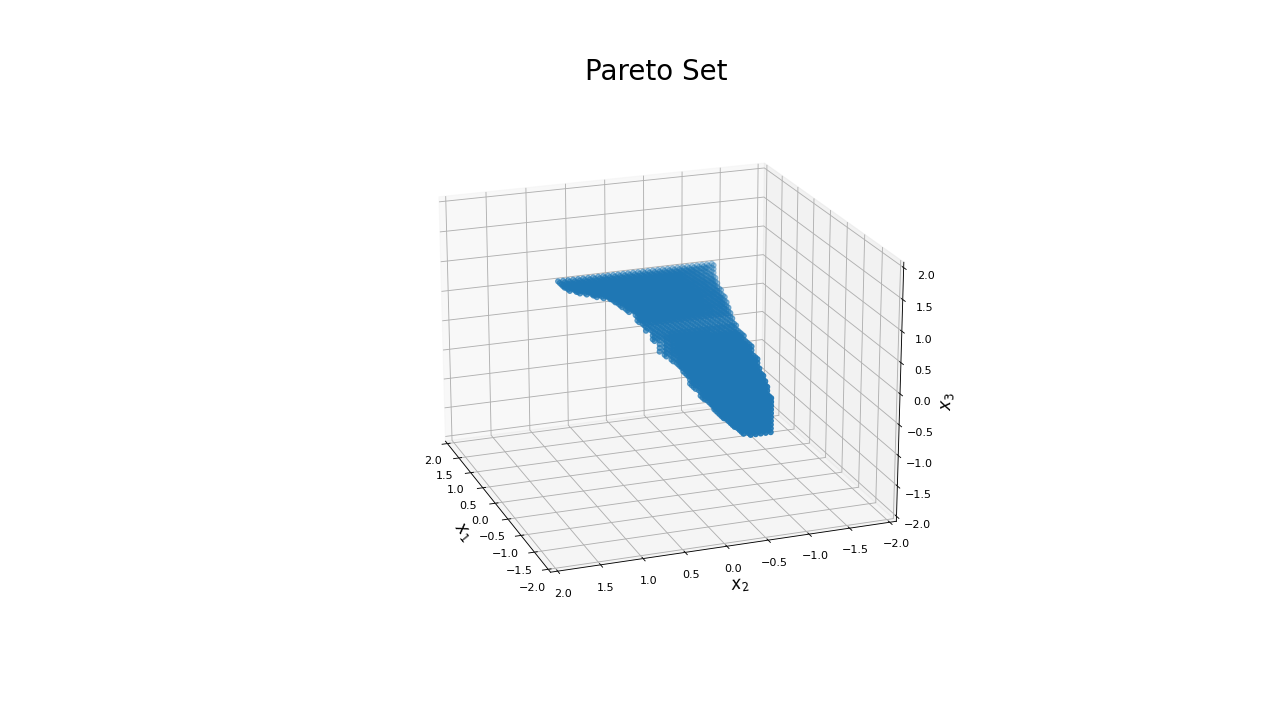

<IPython.core.display.Javascript object>


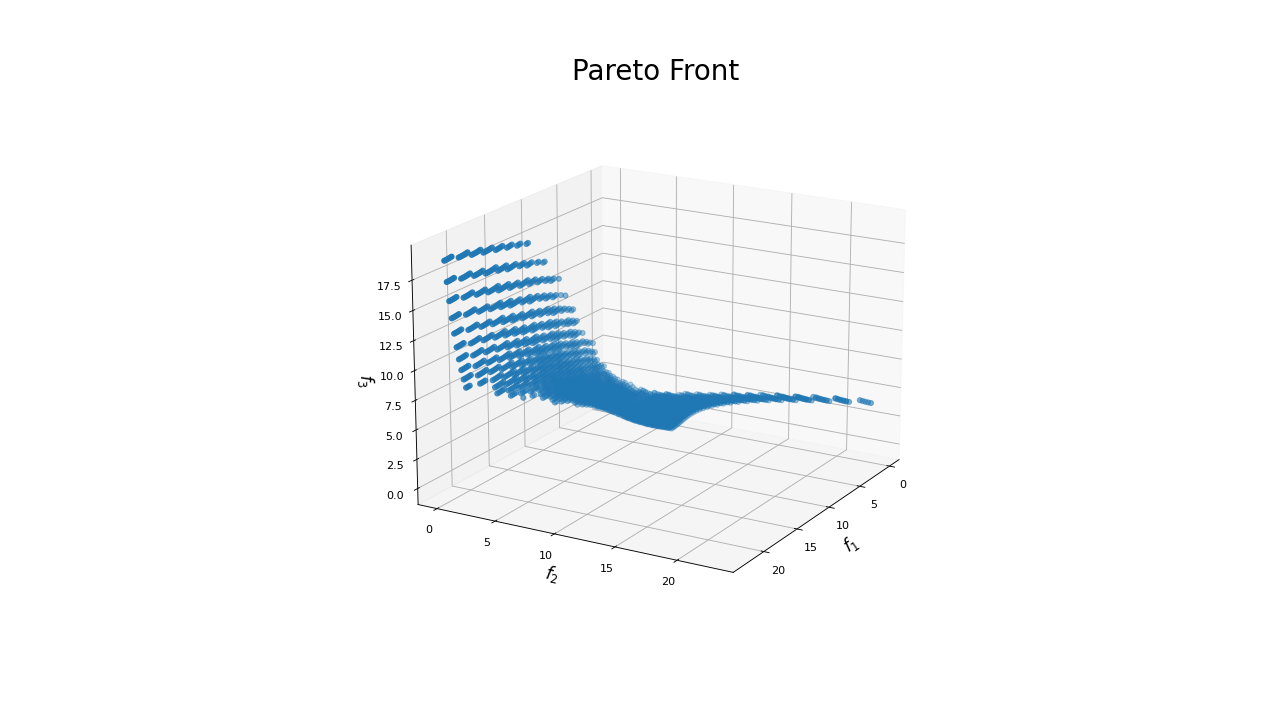

In [9]:
# plot
# plot 3d pareto set
x, y, z = array([leaf.box.center for leaf in root.leaves]).transpose()
fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot(projection='3d', xlim=bounds[0], ylim=bounds[1], zlim=bounds[2])
axes.view_init(20, 160)
axes.set_title("Pareto Set", fontsize=25)
axes.set_xlabel("$x_1$", fontsize=15)
axes.set_ylabel("$x_2$", fontsize=15)
axes.set_zlabel("$x_3$", fontsize=15)
axes.scatter(x, y, z)
plt.show()

# plot 3d pareto front
f, g, h = array([leaf.evaluation for leaf in root.leaves]).transpose()
fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot(projection='3d')
axes.view_init(18, 30)
axes.set_title("Pareto Front", fontsize=25)
axes.set_xlabel("$f_1$", fontsize=15)
axes.set_ylabel("$f_2$", fontsize=15)
axes.set_zlabel("$f_3$", fontsize=15)
axes.scatter(f, g, h)
plt.show()

---

# "Fraktale Strukturen"

Abweichend vom ersten Algorithmus suchen wir nach jeder pareto-Filterung alle aussen liegenden Hyperwürfel. Nur diese werden im nächsten Schritt aufgeteilt. Sollte ein größerer Hyperwürfel pareto-dominiert werden, wird dieser nur aufgeteilt und die kleinere Hyperwürfel werden dann erst wieder im nächsten Schritt betrachtet.

Das Resultat ist eine Zerlegung der Paretomenge in unterschiedlich große Hyperwürfel. Dadurch werden große innen liegende Mengen nicht unnötig aufgeteilt und die Anzahl der Hyperwürfel wird somit reduziert.

In [11]:
# functions
def next_centers(node: MyNode):
    # TODO: could be cleaner/faster (?)
    neighbor_centers = []
    for d in range(node.box.dimension):
        new_center = copy(node.box.center)
        new_center[d] += 2*node.box.radius[d]
        neighbor_centers.append(new_center)
        new_center = copy(node.box.center)
        new_center[d] -= 2*node.box.radius[d]
        neighbor_centers.append(new_center)
    return neighbor_centers


def find_node_containing_point(root_node, point):
    if not root_node.box.is_in(point):
        return None
    else:
        found = False
        result = None

        def check_list(node_list, point):
            for node in node_list:
                if node.box.is_in(point):
                    return node
            else:
                return None

        result = check_list(list([root_node]), point)
        #print(result.box.center, result.box.radius)
        while not found:
            if result is None:
                return result
            elif result.is_leaf:
                return result
            else:
                result = check_list(list(result.children), point)
                #print(result.box.center, result.box.radius)


def flag_outers(root_node: MyNode):
    for leaf in root_node.leaves:
        for center in next_centers(leaf):
            if find_node_containing_point(root_node, center) is None:
                leaf.is_outer = True
                break
    return None



def split_outer_leaves(node: MyNode) -> None:
    for dim in range(node.box.dimension):
        leaves = node.leaves
        for leaf in leaves:
            if leaf.is_outer:
                split_node(leaf, dim, is_outer=True)
            else:
                pass
    return None


def flag_dominated_parents_fractal(node: MyNode) -> None:
    depth = root.height
    while depth > 1:
        for parent in list(LevelOrderGroupIter(root, maxlevel=depth))[-1]:
            if len(parent.children) == 0:
                pass
            elif npall([child.is_dominated for child in parent.children]):
                parent.is_dominated = True
        depth -= 1
    return None


def split_large_dominated(root_node: MyNode) -> bool:
    max_depth = root_node.height
    to_split = findall(root_node, filter_=lambda node: (node.is_dominated) and (node.depth < max_depth))
    if not to_split:
        return False
    else:
        for dim in range(root_node.box.dimension):
            for node in to_split:
                if node.is_leaf:
                    node.is_dominated = False
                    split_node(node, dim)
                else:
                    for leaf in node.leaves:
                        split_node(leaf, dim)
        return True
    
def remove_outer_flag(root_node: MyNode) -> None:
    root_node.is_outer = False
    for node in root_node.descendants:
        node.is_outer = False
    return None

In [12]:
#example two parabolas FRACTAL
initial_splits = 5
total_iterations = 10
min_leaves_for_outer = 0

# set decision boundaries
domain_dim = 2  # =bounds.shape[0]
b1 = array([-2, 2])
b2 = array([-2, 2])
bounds = [b1, b2]

# set objectives
objective_dim = 2
def f1(x): return x[0]**2 + (x[1]-1)**2
def f2(x): return (x[0]-1)**2 + x[1]**2
functions = [f1, f2]

current_iteration = 0

# create root box/node
initial_center = array([b[0]+b[1] for b in bounds]) / 2
initial_radius = array([b[1]-b[0] for b in bounds]) / 2
root = MyNode(initial_center, initial_radius, domain_dim)

# split some iterations before dominance test
for _ in range(initial_splits):
    current_iteration += 1
    full_split_leaves(root)
print("The populaion in iteration {} is {}.".format(
    current_iteration, len(root.leaves)))

# evaluate
for leaf in root.leaves:
    leaf.set_evaluation(array([f(leaf.box.center) for f in functions]))
# dominance test and removal
flag_dominated_leaves(root)
flag_dominated_parents(root)
remove_dominated_leaves(root)
print("The populaion in iteration {} is {} after sampling is applied.".format(
    current_iteration, len(root.leaves)))
######################################################################

while current_iteration < total_iterations:
    if len(root.leaves) < min_leaves_for_outer:
        current_iteration += 1
        # split
        full_split_leaves(root)
        print("The populaion in iteration {} is {} after subsection.".format(
            current_iteration, len(root.leaves)))
        # evaluate
        for leaf in root.leaves:
            leaf.set_evaluation(array([f(leaf.box.center) for f in functions]))
            #print(leaf)
        # dominance test and removal
        # use a very simple (linear) dom test to begin with
        # i could use a seperate(?) domination tree later
        flag_dominated_leaves(root)
        flag_dominated_parents(root)
        remove_dominated_leaves(root)
        print("The populaion in iteration {} is {} after sampling is applied.".format(
            current_iteration, len(root.leaves)))
    else:
        current_iteration += 1
        # find outers (only checks smalles boxes)
        flag_outers(root)
        # split outers
        split_outer_leaves(root)
        print("The populaion in iteration {} is {} after subsection.".format(
            current_iteration, len(root.leaves)))
        remove_outer_flag(root)
        # evaluate
        for leaf in root.leaves:
            leaf.set_evaluation(array([f(leaf.box.center) for f in functions]))
        # dominance test
        flag_dominated_leaves(root)
        while split_large_dominated(root):
            for leaf in root.leaves:
                leaf.set_evaluation(array([f(leaf.box.center) for f in functions]))
            flag_dominated_leaves(root)
        flag_dominated_parents_fractal(root)
        remove_dominated_leaves(root)
        print("The populaion in iteration {} is {} after sampling is applied.".format(
            current_iteration, len(root.leaves)))

The populaion in iteration 5 is 1024.
The populaion in iteration 5 is 22 after sampling is applied.
The populaion in iteration 6 is 70 after subsection.
The populaion in iteration 6 is 52 after sampling is applied.
The populaion in iteration 7 is 172 after subsection.
The populaion in iteration 7 is 108 after sampling is applied.
The populaion in iteration 8 is 384 after subsection.
The populaion in iteration 8 is 226 after sampling is applied.
The populaion in iteration 9 is 814 after subsection.
The populaion in iteration 9 is 430 after sampling is applied.
The populaion in iteration 10 is 1594 after subsection.
The populaion in iteration 10 is 936 after sampling is applied.


In [13]:
# DEBUG plot
# plot 2d pareto set

#outers = list(filter(lambda node: node.is_dominated, root.leaves))
#inners = list(filter(lambda node: not node.is_dominated, root.leaves))
#
#fig = plt.figure(figsize=(16, 9), dpi=80)
#axes = fig.add_subplot(xlim=bounds[0], ylim=bounds[1])
#axes.set_box_aspect(1)
## axes.view_init(20, 160)
#axes.set_title("Pareto Set", fontsize=25)
#axes.set_xlabel("$x_1$", fontsize=15)
#axes.set_ylabel("$x_2$", fontsize=15)
#if len(outers) > 0:
#    x, y = array([leaf.box.center for leaf in outers]).transpose()
#    axes.scatter(x, y, s=10, marker='o', color='red')
#if len(inners) > 0:
#    xi, yi = array([leaf.box.center for leaf in inners]).transpose()
#    axes.scatter(xi, yi, s=10, marker='o', color='blue')
#plt.show()

<IPython.core.display.Javascript object>


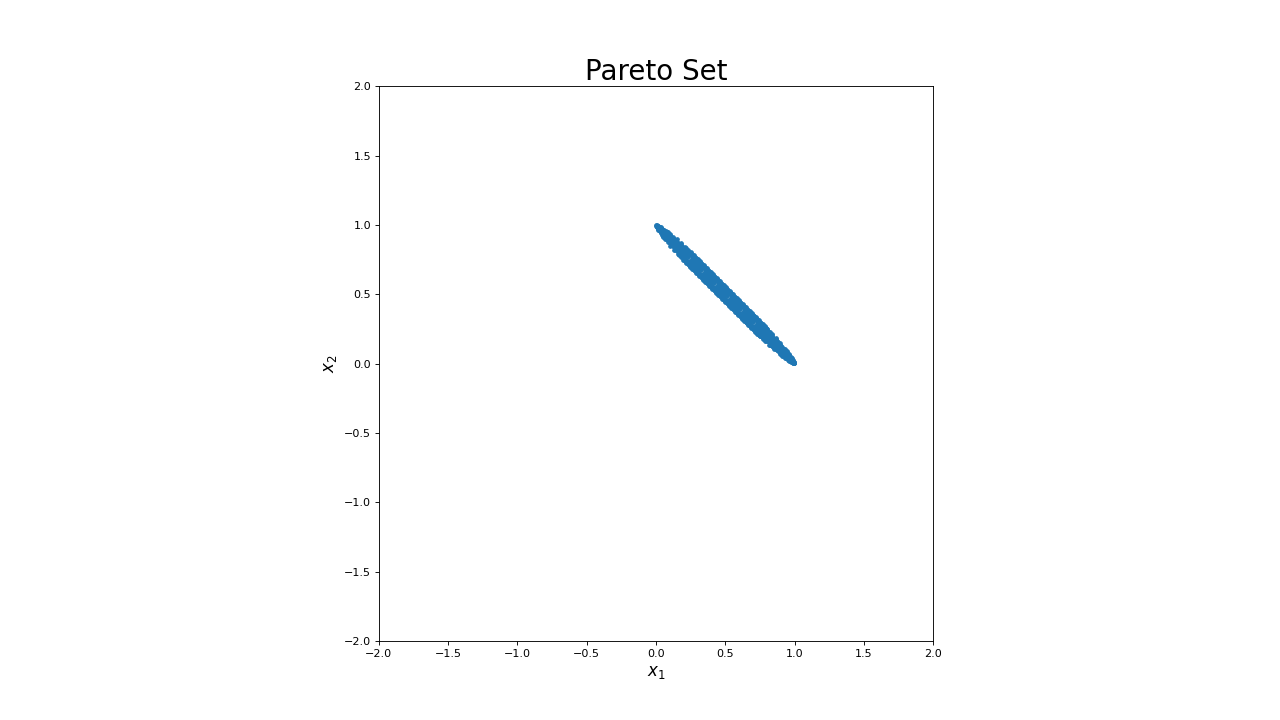

<IPython.core.display.Javascript object>


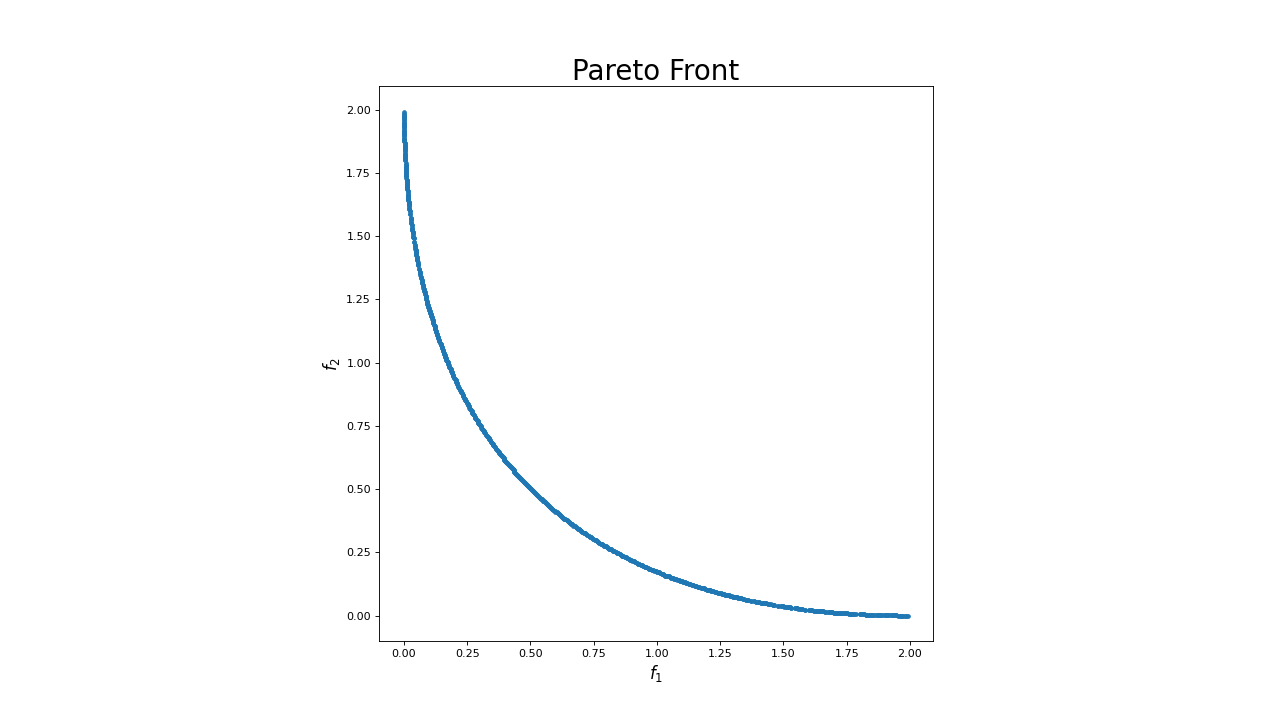

In [14]:
# plot
# plot 2d pareto set
x, y = array([leaf.box.center for leaf in root.leaves]).transpose()
fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot(xlim=bounds[0], ylim=bounds[1])
axes.set_box_aspect(1)
# axes.view_init(20, 160)
axes.set_title("Pareto Set", fontsize=25)
axes.set_xlabel("$x_1$", fontsize=15)
axes.set_ylabel("$x_2$", fontsize=15)
axes.scatter(x, y, s=10, marker='o')
plt.show()

# plot 2d pareto front
f, g = array([leaf.evaluation for leaf in root.leaves]).transpose()
fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot()
axes.set_box_aspect(1)
axes.set_title("Pareto Front", fontsize=25)
axes.set_xlabel("$f_1$", fontsize=15)
axes.set_ylabel("$f_2$", fontsize=15)
axes.scatter(f, g, s=10, marker='o')
plt.show()

In [15]:
# example Peitz fractal
initial_splits = 3
total_iterations = 7

# set decision boundaries
domain_dim = 3
bounds_x1 = array([-2, 2])
bounds_x2 = array([-2, 2])
bounds_x3 = array([-2, 2])
bounds = [bounds_x1, bounds_x2, bounds_x3]

# set objectives
objective_dim = 3
def func_1(x): return (x[0]-1)**4 + (x[1]-1)**2 + (x[2]-1)**2
def func_2(x): return (x[0]+1)**2 + (x[1]+1)**4 + (x[2]+1)**2
def func_3(x): return (x[0]-1)**2 + (x[1]+1)**2 + (x[2]-1)**4
functions = [func_1, func_2, func_3]

current_iteration = 0

# create root box/node
initial_center = array([b[0]+b[1] for b in bounds]) / 2
initial_radius = array([b[1]-b[0] for b in bounds]) / 2
root = MyNode(initial_center, initial_radius, domain_dim)

# split some iterations before dominance test
for _ in range(initial_splits):
    current_iteration += 1
    full_split_leaves(root)
print("The populaion in iteration {} is {}.".format(
    current_iteration, len(root.leaves)))

while current_iteration < total_iterations:
    if len(root.leaves) < min_leaves_for_outer:
        current_iteration += 1
        # split
        full_split_leaves(root)
        print("The populaion in iteration {} is {} after subsection.".format(
            current_iteration, len(root.leaves)))
        # evaluate
        for leaf in root.leaves:
            leaf.set_evaluation(array([f(leaf.box.center) for f in functions]))
            #print(leaf)
        # dominance test and removal
        # use a very simple (linear) dom test to begin with
        # i could use a seperate(?) domination tree later
        flag_dominated_leaves(root)
        flag_dominated_parents(root)
        remove_dominated_leaves(root)
        print("The populaion in iteration {} is {} after sampling is applied.".format(
            current_iteration, len(root.leaves)))
    else:
        current_iteration += 1
        # find outers (only checks smalles boxes)
        flag_outers(root)
        # split outers
        split_outer_leaves(root)
        print("The populaion in iteration {} is {} after subsection.".format(
            current_iteration, len(root.leaves)))
        remove_outer_flag(root)
        # evaluate
        for leaf in root.leaves:
            leaf.set_evaluation(array([f(leaf.box.center) for f in functions]))
        # dominance test
        flag_dominated_leaves(root)
        while split_large_dominated(root):
            for leaf in root.leaves:
                leaf.set_evaluation(array([f(leaf.box.center) for f in functions]))
            flag_dominated_leaves(root)
        flag_dominated_parents_fractal(root)
        remove_dominated_leaves(root)
        print("The populaion in iteration {} is {} after sampling is applied.".format(
            current_iteration, len(root.leaves)))
    
# for plots:
flag_outers(root)

The populaion in iteration 3 is 512.
The populaion in iteration 4 is 2584 after subsection.
The populaion in iteration 4 is 109 after sampling is applied.
The populaion in iteration 5 is 858 after subsection.
The populaion in iteration 5 is 429 after sampling is applied.
The populaion in iteration 6 is 3229 after subsection.
The populaion in iteration 6 is 1616 after sampling is applied.
The populaion in iteration 7 is 11822 after subsection.
The populaion in iteration 7 is 6311 after sampling is applied.


<IPython.core.display.Javascript object>


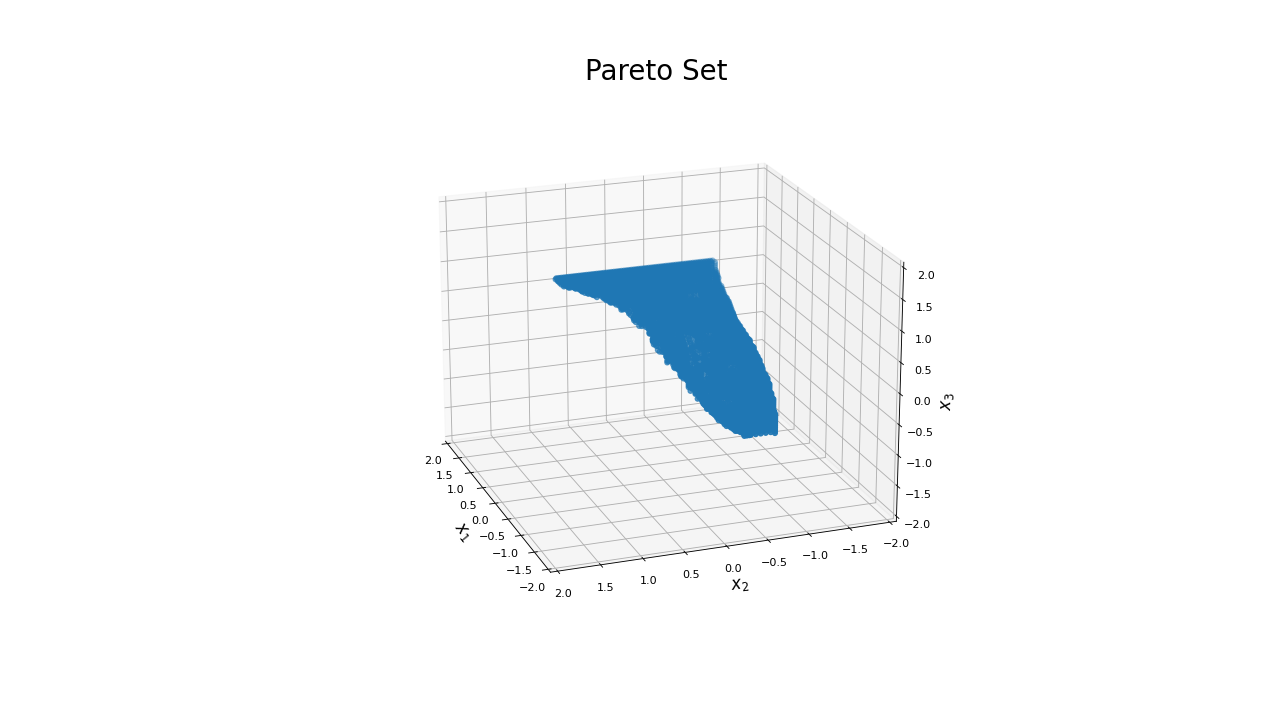

<IPython.core.display.Javascript object>


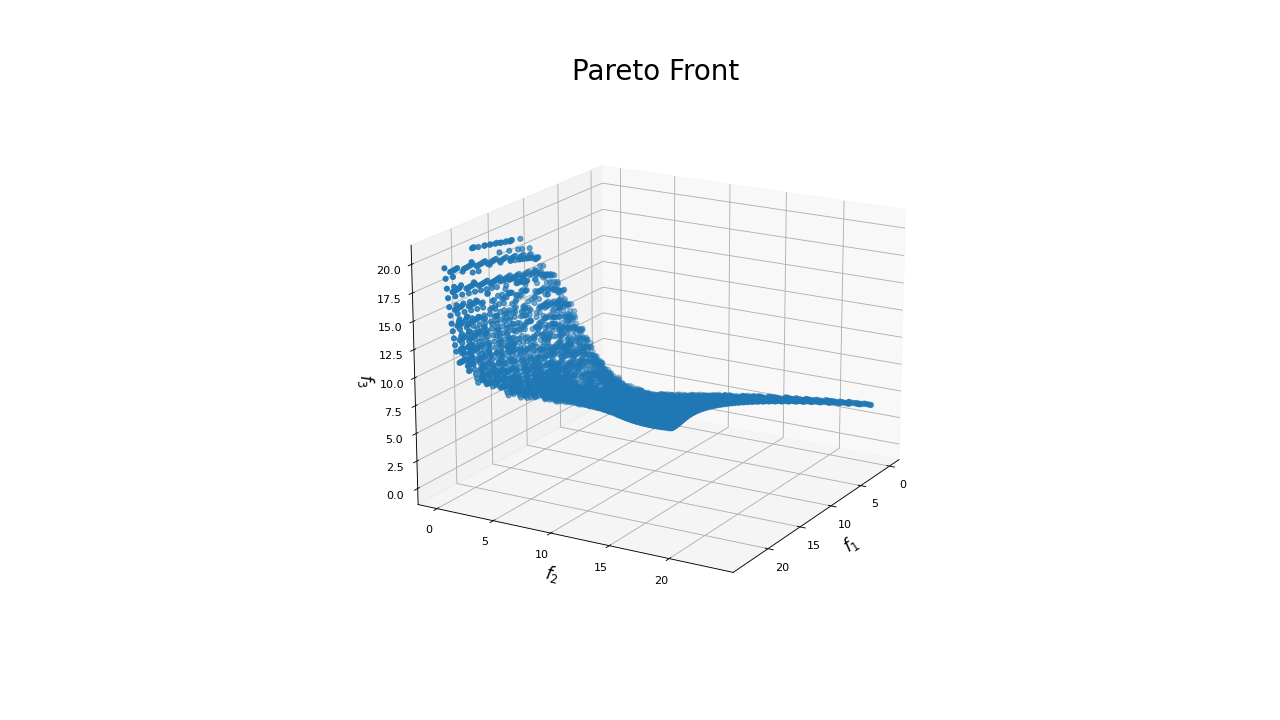

In [16]:
# plot
# plot 3d pareto set
x, y, z = array([leaf.box.center for leaf in root.leaves]).transpose()
fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot(projection='3d', xlim=bounds[0], ylim=bounds[1], zlim=bounds[2])
axes.view_init(20, 160)
axes.set_title("Pareto Set", fontsize=25)
axes.set_xlabel("$x_1$", fontsize=15)
axes.set_ylabel("$x_2$", fontsize=15)
axes.set_zlabel("$x_3$", fontsize=15)
axes.scatter(x, y, z)
plt.show()

# plot 3d pareto front
f, g, h = array([leaf.evaluation for leaf in root.leaves]).transpose()
fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot(projection='3d')
axes.view_init(18, 30)
axes.set_title("Pareto Front", fontsize=25)
axes.set_xlabel("$f_1$", fontsize=15)
axes.set_ylabel("$f_2$", fontsize=15)
axes.set_zlabel("$f_3$", fontsize=15)
axes.scatter(f, g, h)
plt.show()

<IPython.core.display.Javascript object>


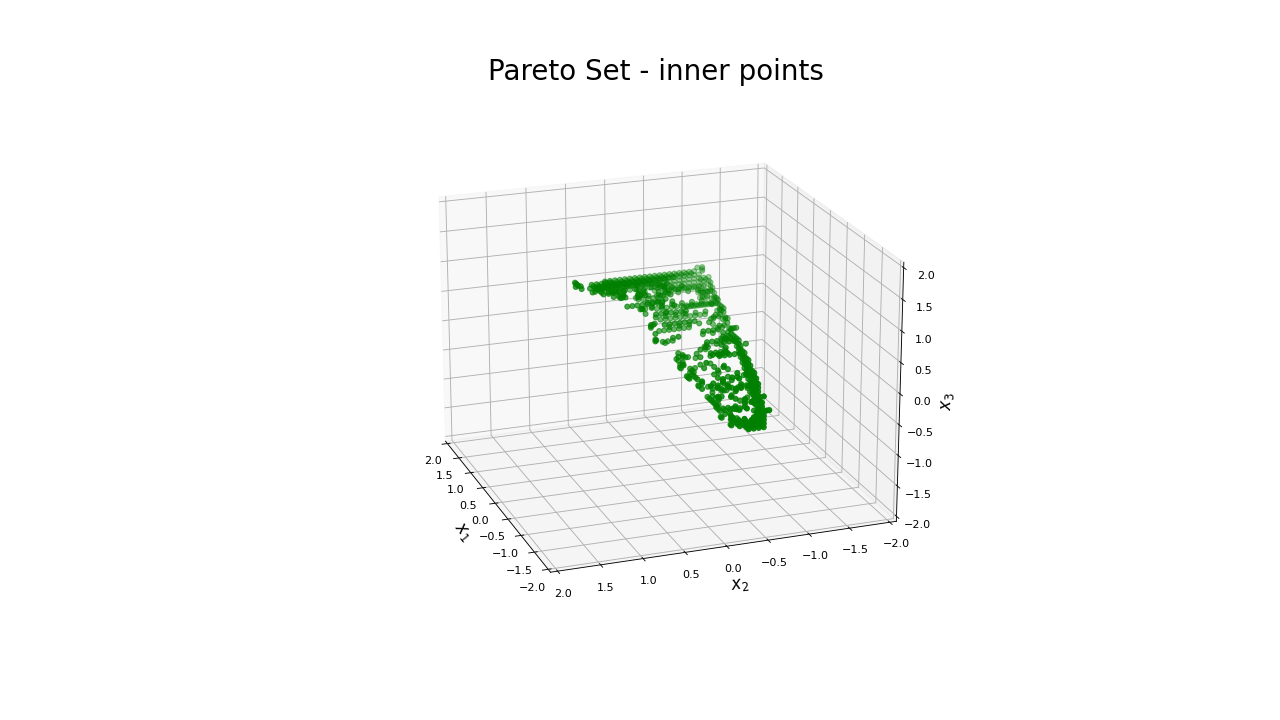

<IPython.core.display.Javascript object>


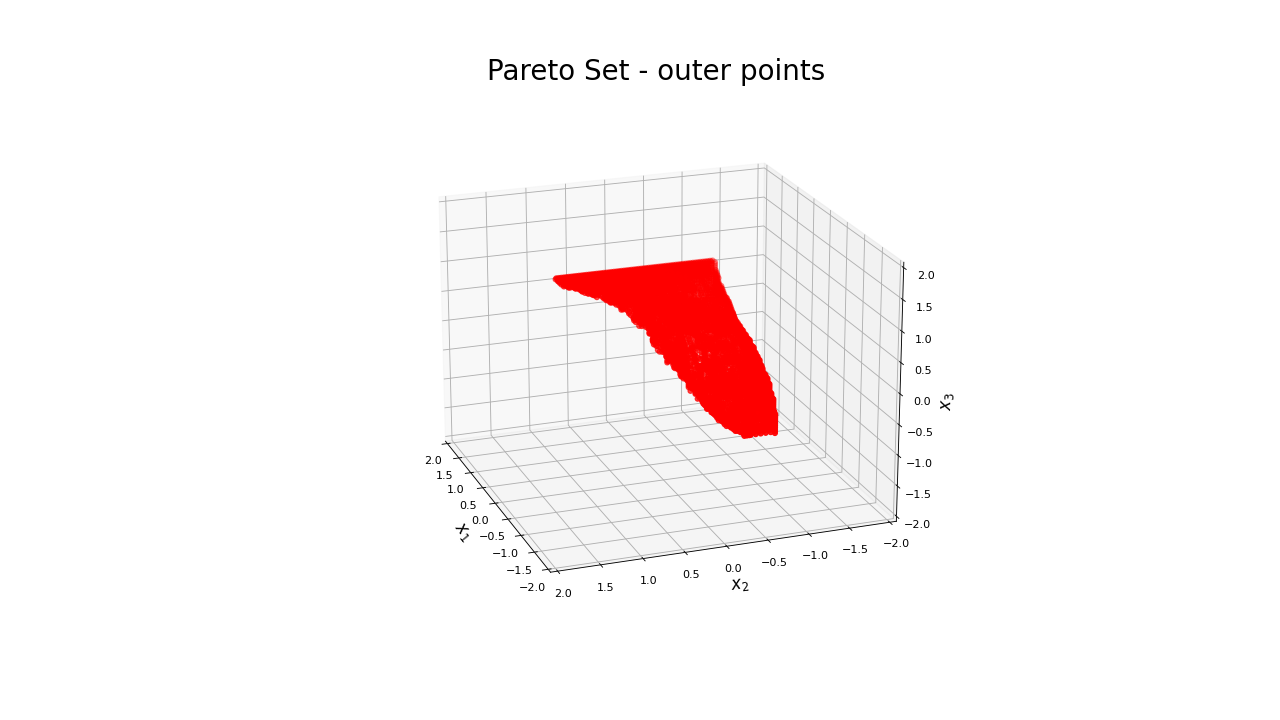

<IPython.core.display.Javascript object>


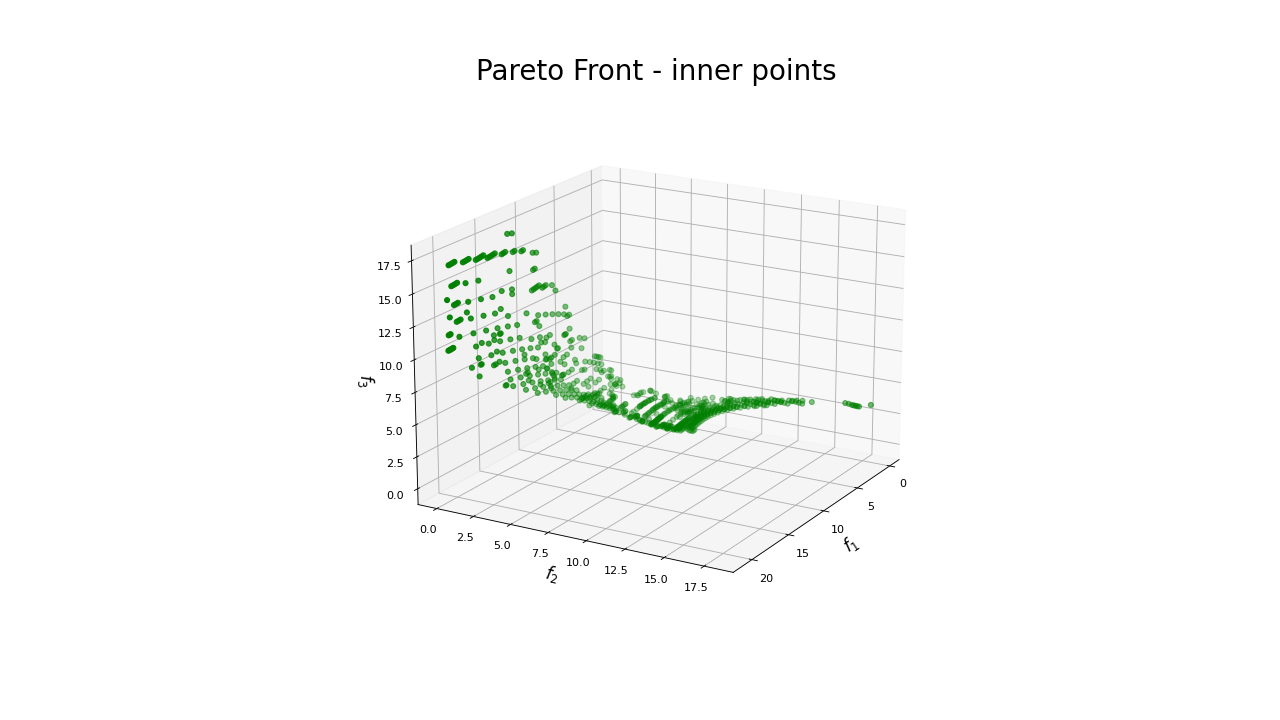

<IPython.core.display.Javascript object>


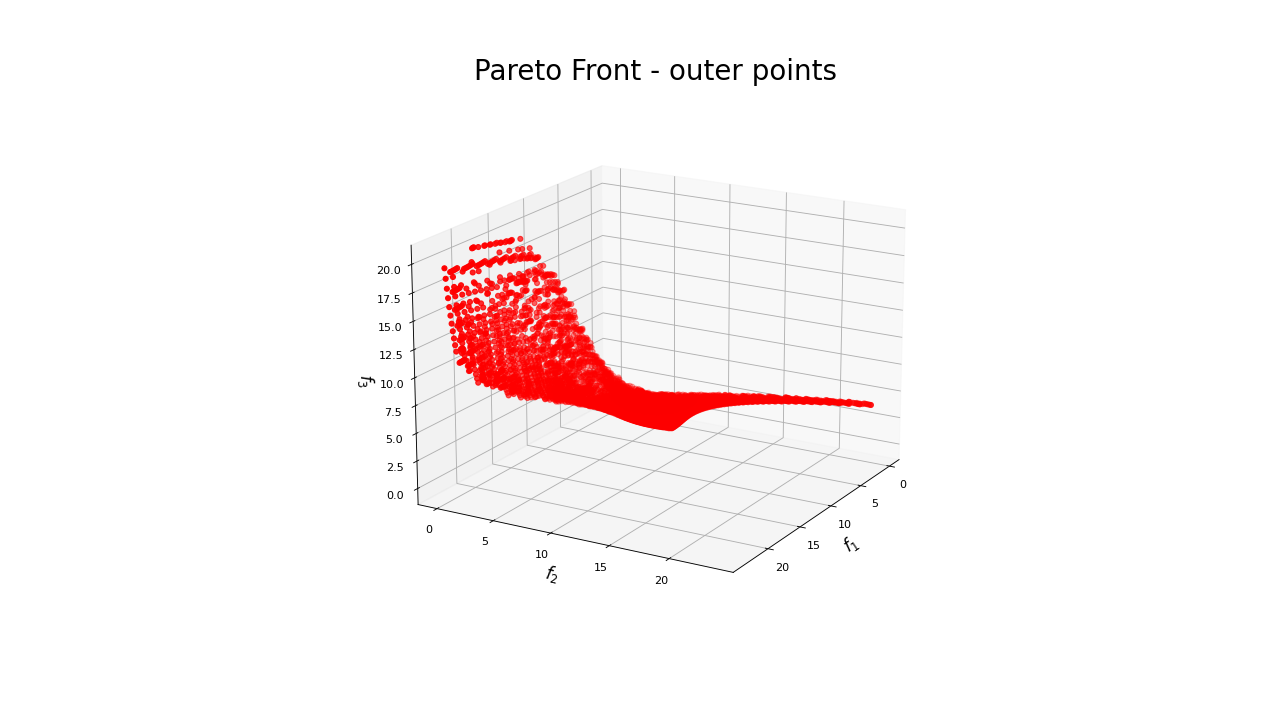

In [17]:
# plot with colors # %matplotlib notebook
flag_outers(root)
# plot
# plot 3d pareto set
nodes = list(root.leaves)
outers = list(filter(lambda node: node.is_outer, nodes))
inners = list(filter(lambda node: not node.is_outer, nodes))

xo, yo, zo = array([node.box.center for node in outers]).transpose()
xi, yi, zi = array([node.box.center for node in inners]).transpose()
fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot(projection='3d', xlim=bounds[0], ylim=bounds[1], zlim=bounds[2])
axes.view_init(20, 160)
axes.set_title("Pareto Set - inner points", fontsize=25)
axes.set_xlabel("$x_1$", fontsize=15)
axes.set_ylabel("$x_2$", fontsize=15)
axes.set_zlabel("$x_3$", fontsize=15)
#axes.scatter(xo, yo, zo, color='red')
axes.scatter(xi, yi, zi, color='green')
plt.show()

fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot(projection='3d', xlim=bounds[0], ylim=bounds[1], zlim=bounds[2])
axes.view_init(20, 160)
axes.set_title("Pareto Set - outer points", fontsize=25)
axes.set_xlabel("$x_1$", fontsize=15)
axes.set_ylabel("$x_2$", fontsize=15)
axes.set_zlabel("$x_3$", fontsize=15)
axes.scatter(xo, yo, zo, color='red')
#axes.scatter(xi, yi, zi, color='green')
plt.show()

# plot 3d pareto front
fo, go, ho = array([node.evaluation for node in outers]).transpose()
fi, gi, hi = array([node.evaluation for node in inners]).transpose()
fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot(projection='3d')
axes.view_init(18, 30)
axes.set_title("Pareto Front - inner points", fontsize=25)
axes.set_xlabel("$f_1$", fontsize=15)
axes.set_ylabel("$f_2$", fontsize=15)
axes.set_zlabel("$f_3$", fontsize=15)
#axes.scatter(fo, go, ho, color='red')
axes.scatter(fi, gi, hi, color='green')
plt.show()

fig = plt.figure(figsize=(16, 9), dpi=80)
axes = fig.add_subplot(projection='3d')
axes.view_init(18, 30)
axes.set_title("Pareto Front - outer points", fontsize=25)
axes.set_xlabel("$f_1$", fontsize=15)
axes.set_ylabel("$f_2$", fontsize=15)
axes.set_zlabel("$f_3$", fontsize=15)
axes.scatter(fo, go, ho, color='red')
#axes.scatter(fi, gi, hi, color='green')
plt.show()